In [1]:
import os
from plantcv import plantcv as pcv 
# import analyze_area
import json
import cv2
from matplotlib import pyplot as plt
import numpy as np
import cluster_jordan 
import math
import show_objects

# set to "plot" to see image at every step (takes longer)
class options:
    def __init__(self):
        self.debug = "plot"
        self.writeimg= False
        self.result = "vis_tutorial_results.json"
        self.outdir = "." # Store the output to the current directory
        
# Get options
args = options()

# Set debug to the global parameter 
pcv.params.debug = args.debug

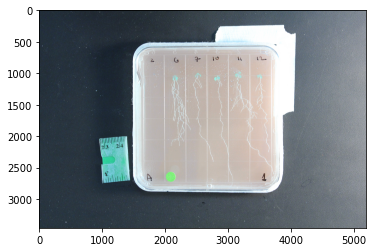

In [2]:
imagelink = f"./test_images/IMG_7454.jpg"
image = cv2.imread(imagelink)
shape = np.shape(image)

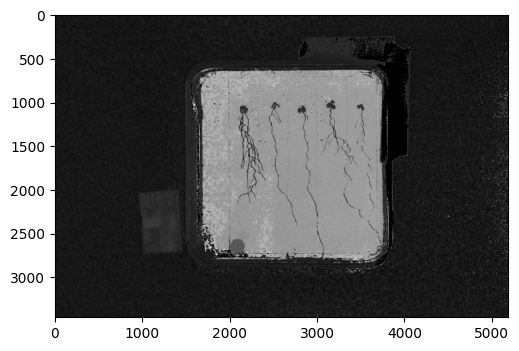

In [41]:
thresh = pcv.rgb2gray_hsv(rgb_img=image, channel="h")
#Other channels of differen colorspaces may be appropriate for other images for example:
#thresh = pcv.rgb2gray_lab(rgb_img=image, channel="l") 
#thresh= pcv.rgb2gray_cmyk(rgb_img =image, channel="y")

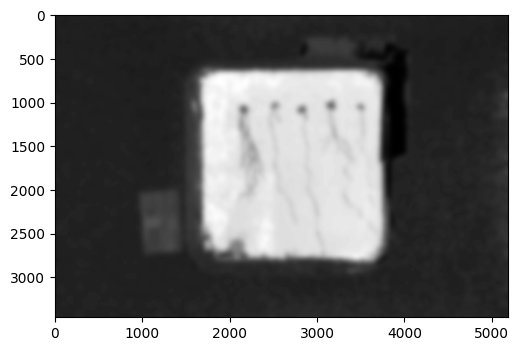

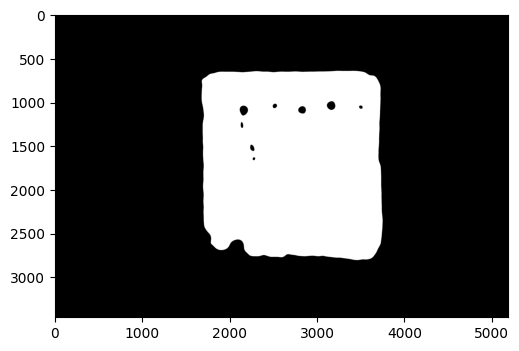

In [42]:
thresh = pcv.gaussian_blur(img=thresh, ksize=(201, 201), sigma_x=0, sigma_y=None)
thresh = pcv.threshold.binary(gray_img=thresh, threshold=80, max_value=325, object_type="light")

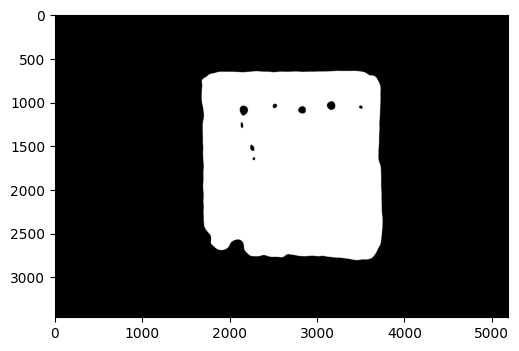

In [43]:
fill = pcv.fill(bin_img=thresh, size=350000)


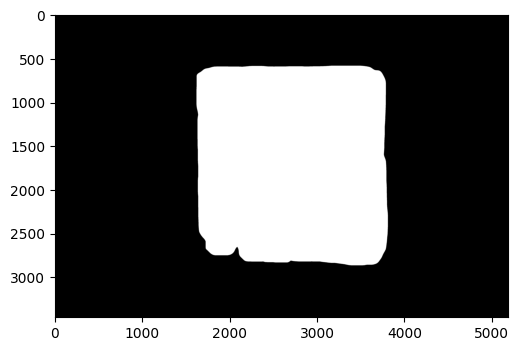

In [44]:
dilate = pcv.dilate(gray_img=fill, ksize=120, i=1)



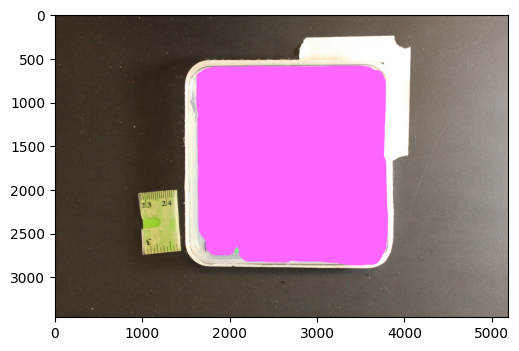

[[[-1 -1 -1 -1]]]


In [45]:
id_objects, obj_hierarchy = pcv.find_objects(img=image, mask=dilate)
#id_objects, obj_hierarchy = pcv.find_objects(img=image, mask=fill)
print(obj_hierarchy)

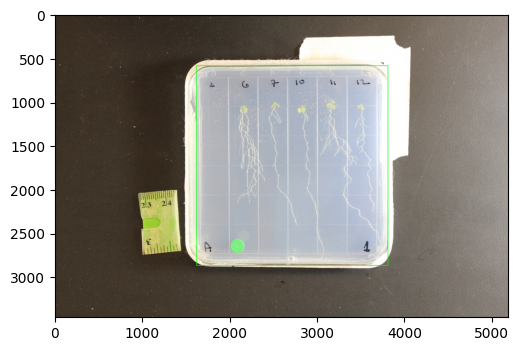

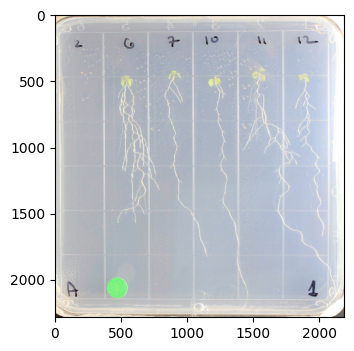

In [46]:
cnt = id_objects[0]
#x,y,w,h = cv2.minAreaRect(cnt)
#x,y,w,h = cv2.boundingRect(cnt)
img = pcv.auto_crop(img = image, obj = cnt)
#img = image[(y):(y+h),(x):(x+w)]
#plt.imshow(img)
rect = cv2.minAreaRect(cnt)
box = cv2.boxPoints(rect)
box = np.int0(box)
#im3 = cv2.drawContours(image,[box],0,(0,0,255),5)
#plt.imshow(im3)

(2285, 2191, 3)
89.14277648925781


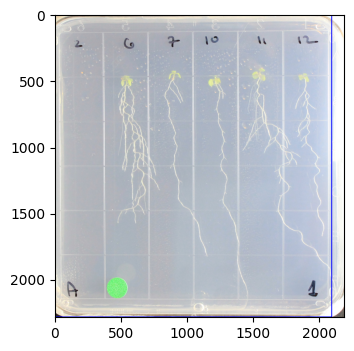

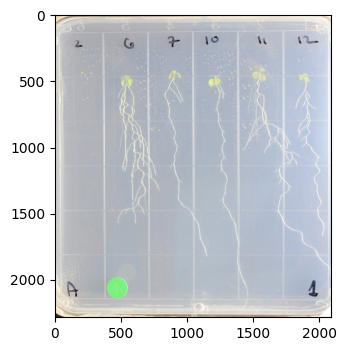

In [47]:
shape = np.shape(img)
angle = rect[2]
print(shape)
center = rect[0]
width, height = rect[1]
height = height
print(angle)
if angle > 45:
    angle = angle-90
if angle > 1.0 or angle < -1.0:
    M = cv2.getRotationMatrix2D(center,angle,1.0)
    img = cv2.warpAffine(img, M, (int(shape[1]), int(shape[0])))
    img = pcv.crop(img=img, x=10, y=100, h=shape[0]-100, w=shape[1]-110)
else:
    img = pcv.crop(img=img, x=0, y=0, h=shape[0], w=shape[1]-100)

crp_image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(crp_image)


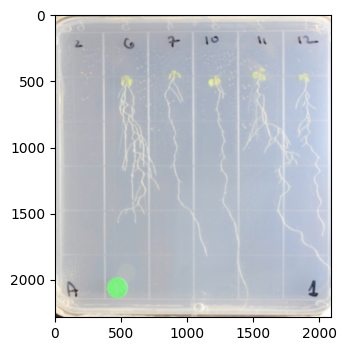

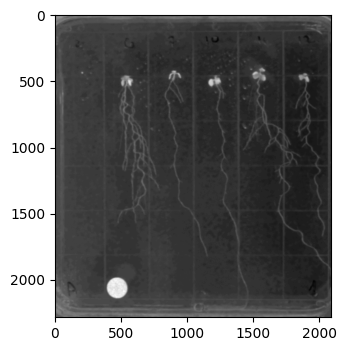

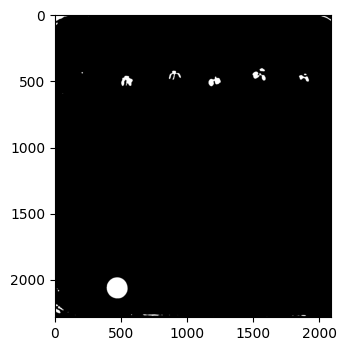

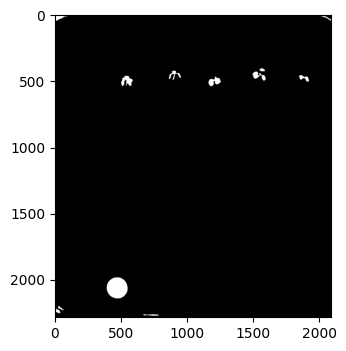

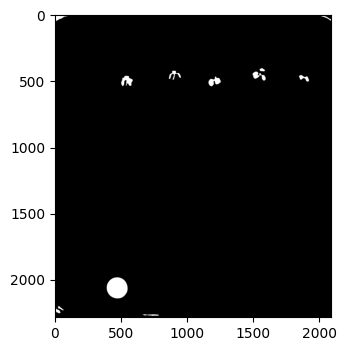

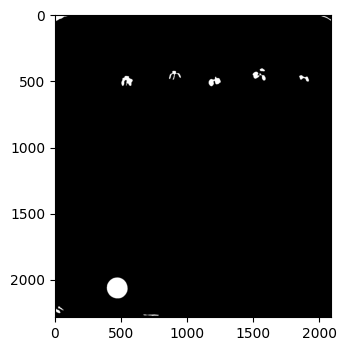

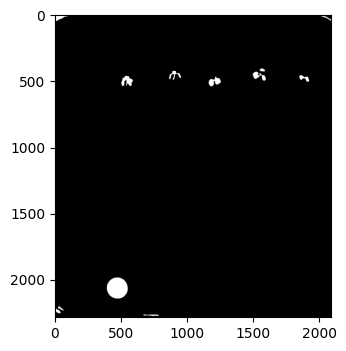

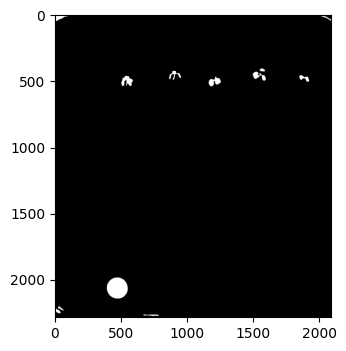

In [48]:
blur = pcv.gaussian_blur(img=img, ksize=(21, 21), sigma_x=0, sigma_y=None)

b = pcv.rgb2gray_lab(rgb_img=blur, channel="b")
avg = np.average(img)
std = np.std(img)
if avg > 220 and std < 25:
    b = pcv.hist_equalization(b)
    t = 251
else: 
    t = 148
# defining a threshold between the leaf and the background
b_thresh = pcv.threshold.binary(gray_img=b, threshold= t-6, max_value=255, object_type="light")
bsa_fill1 = pcv.fill(bin_img=b_thresh, size=300)
bsa_fill1 = pcv.closing(gray_img=bsa_fill1)
bsa_fill1 = pcv.erode(gray_img = bsa_fill1, ksize = 2, i = 1)
bsa_fill1 = pcv.dilate(gray_img=bsa_fill1, ksize = 2, i = 1)
bsa_fill1 = pcv.fill(bin_img=bsa_fill1, size=300)

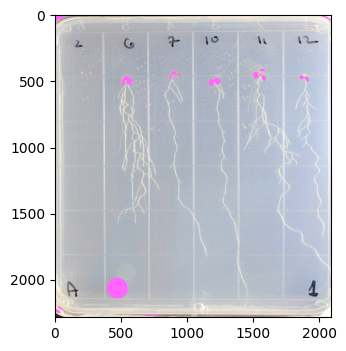

[array([[[ 669, 2266]],

       [[ 668, 2267]],

       [[ 667, 2267]],

       [[ 666, 2268]],

       [[ 665, 2268]],

       [[ 665, 2269]],

       [[ 666, 2269]],

       [[ 667, 2270]],

       [[ 668, 2270]],

       [[ 669, 2270]],

       [[ 670, 2271]],

       [[ 671, 2271]],

       [[ 672, 2271]],

       [[ 673, 2272]],

       [[ 674, 2272]],

       [[ 675, 2272]],

       [[ 676, 2273]],

       [[ 677, 2273]],

       [[ 678, 2273]],

       [[ 679, 2273]],

       [[ 680, 2273]],

       [[ 681, 2273]],

       [[ 682, 2273]],

       [[ 683, 2273]],

       [[ 684, 2273]],

       [[ 685, 2272]],

       [[ 686, 2272]],

       [[ 687, 2272]],

       [[ 688, 2272]],

       [[ 689, 2272]],

       [[ 690, 2272]],

       [[ 691, 2272]],

       [[ 692, 2272]],

       [[ 693, 2272]],

       [[ 694, 2272]],

       [[ 695, 2272]],

       [[ 696, 2271]],

       [[ 697, 2271]],

       [[ 698, 2271]],

       [[ 699, 2271]],

       [[ 700, 2271]],

       [[ 701, 

In [49]:
id_objects, obj_hierarchy = pcv.find_objects(img=img, mask=bsa_fill1)

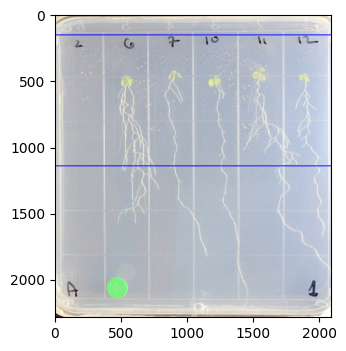

In [50]:
shape = np.shape(img)
roi_contour, roi_hierarchy = pcv.roi.rectangle(img=img, x=0, y=150, h=(shape[0]/2)-150, w=shape[1])

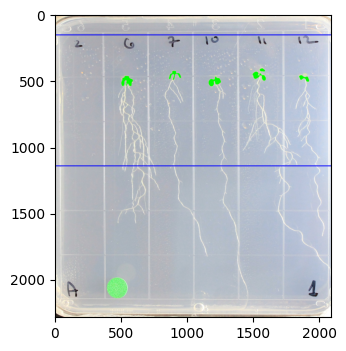

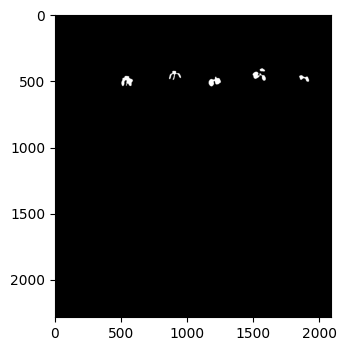

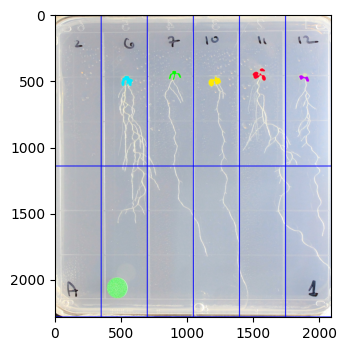

This function has been updated to include object hierarchy so object holes can be included


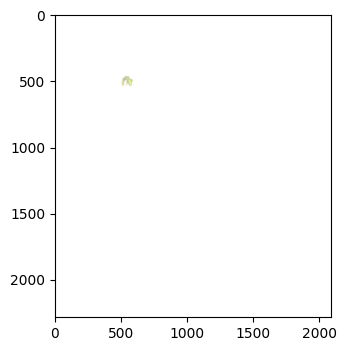

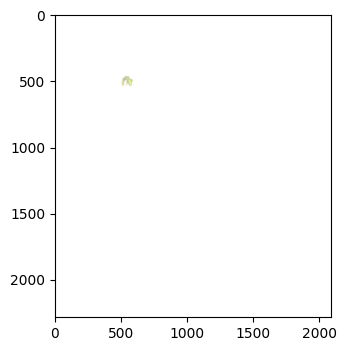

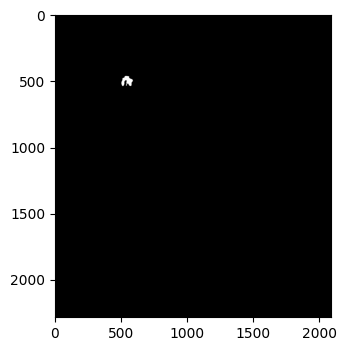

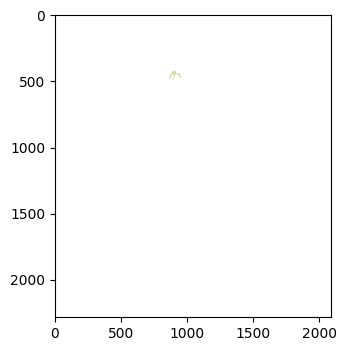

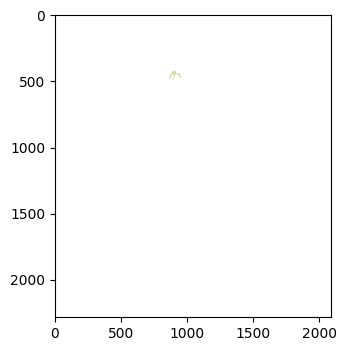

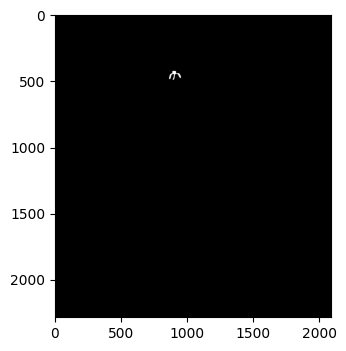

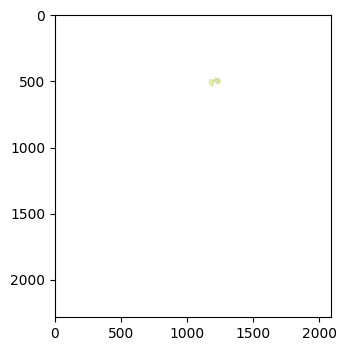

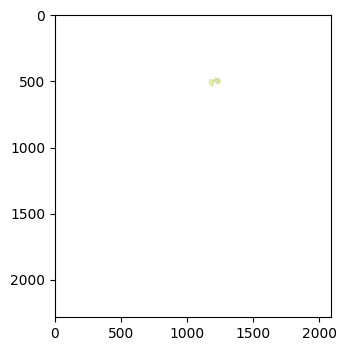

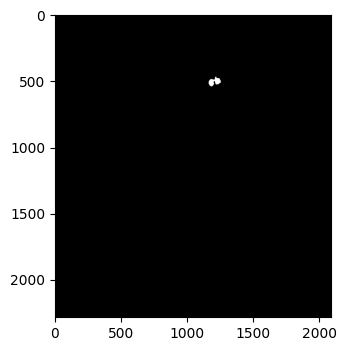

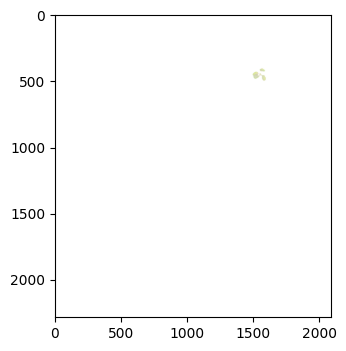

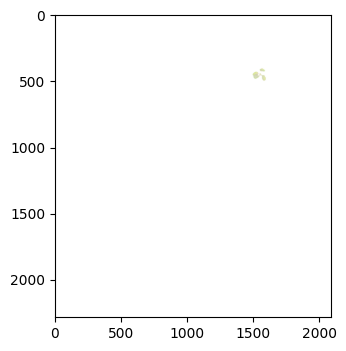

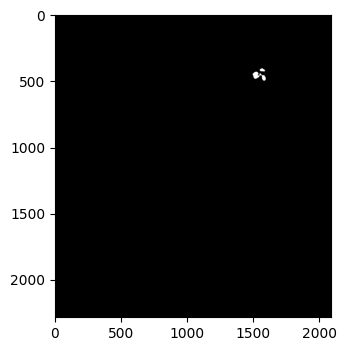

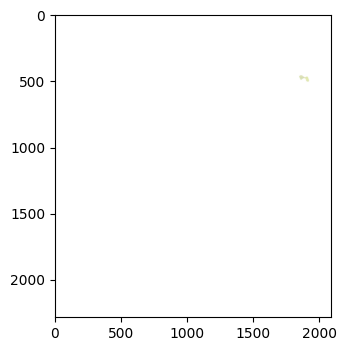

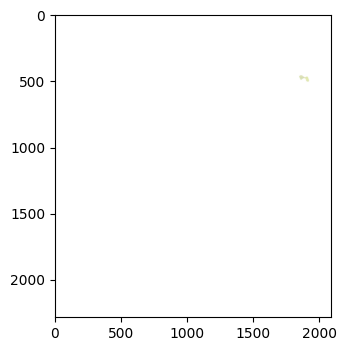

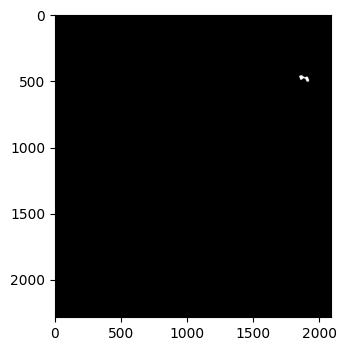

In [51]:
# gives 4 diff outputs
# list of objs, hierarchies say object or hole w/i object
roi_objects, hierarchy, kept_mask, obj_area = pcv.roi_objects(img=img, 
                                                              roi_contour=roi_contour, roi_hierarchy=roi_hierarchy,
                                                              object_contour=id_objects, obj_hierarchy=obj_hierarchy, roi_type="partial")

# clustering defined leaves into individual plants using predefined rows/cols
clusters_i, contours, hierarchies = cluster_jordan.cluster_contours(img=img, roi_objects=roi_objects, 
                                                         roi_obj_hierarchy=hierarchy, nrow=2, ncol=6, show_grid=True)
# split the clusters into individual images for analysis
output_path, imgs, masks = cluster_jordan.cluster_contour_splitimg(rgb_img=img,
                                                        grouped_contour_indexes=clusters_i, contours=contours, 
                                                        hierarchy=hierarchies)

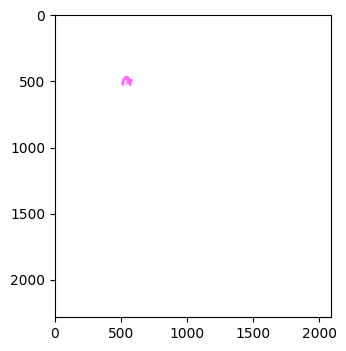

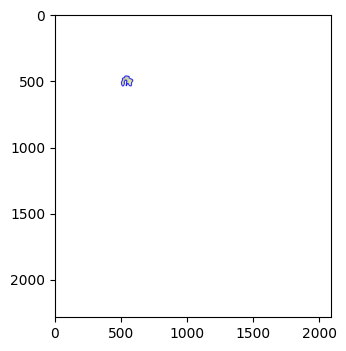

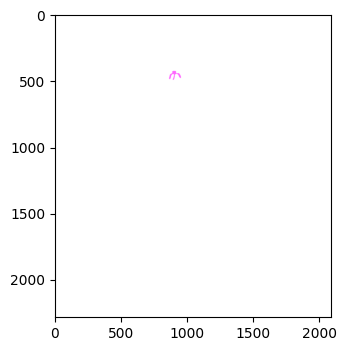

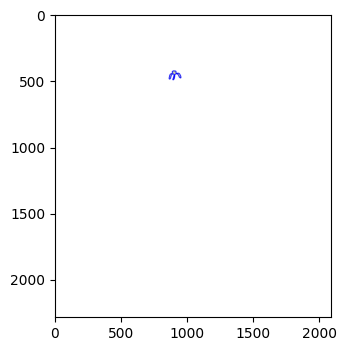

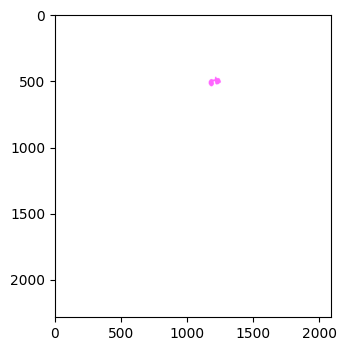

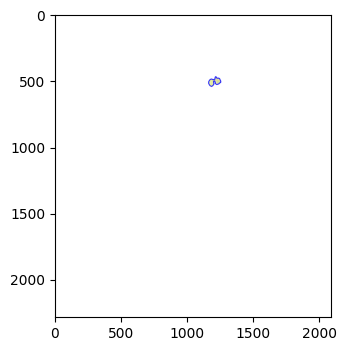

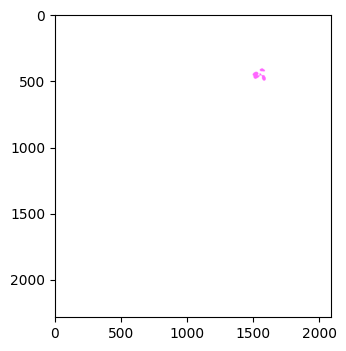

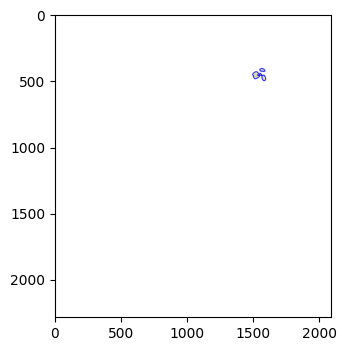

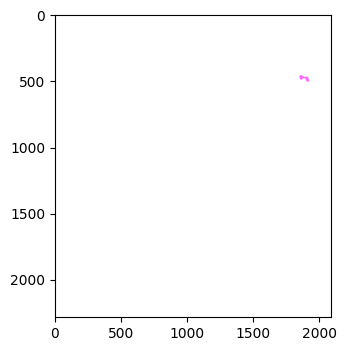

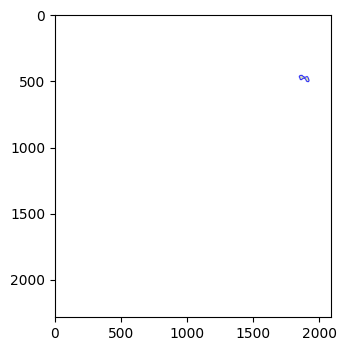

{6: 0, 5: 3899.0, 4: 1911.0, 3: 3615.5, 2: 3557.5, 1: 1670.0}


In [52]:
sus = False
num_plants = 0
areas = {}

for i in range(0,6):
    pos = 7-(i+1)
    if clusters_i[i][0] != None:
        id_objects, obj_hierarchy = pcv.find_objects(img=imgs[num_plants], mask=masks[num_plants])
        obj, mask1 = pcv.object_composition(img=imgs[num_plants], contours=id_objects, hierarchy=obj_hierarchy)
        m = cv2.moments(obj)
        area = m['m00']
        num_plants += 1
        center, expect_r = cv2.minEnclosingCircle(obj)
        r = math.sqrt(area/math.pi)
        leaf_error = False
        if r <= 0.35*expect_r:
            leaf_error = True
            sus = True
            print(f"warning: there may be an error detecting leaf {pos}")

        areas[pos] = area
    else:
        areas[pos] = 0
print(areas)

In [53]:
scale_crop = img

(2285, 2091, 3)
(2285, 2091, 3)


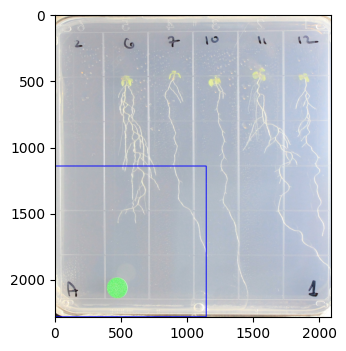

In [54]:

shape = np.shape(scale_crop)
print(shape)
print(scale_crop.shape)
#roi_contour_scale, roi_hierarchy_scale = pcv.roi.rectangle(img=scale_crop, x=0, y=shape[0]/2, h=shape[0]/2, w=shape[0]/2)
scale_crop = pcv.crop(img=scale_crop, x=0, y=int(shape[0]/2), h=int(shape[0]/2), w=int(shape[0]/2))
#roi_contour, roi_hierarchy = pcv.roi.rectangle(img=img, x=0, y=0, h=shape[0]/2, w=shape[1])

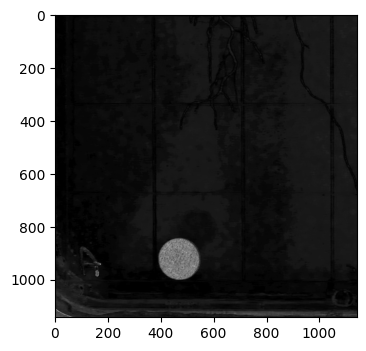

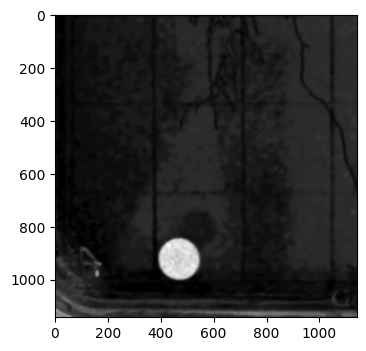

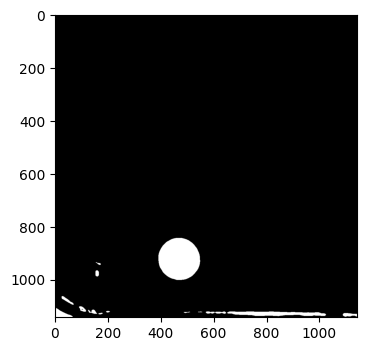

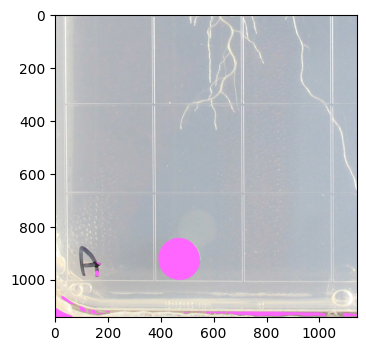

In [55]:
pcv.params.debug = "plot"
a_scale = pcv.rgb2gray_hsv(rgb_img=scale_crop, channel="s")
a_scale = pcv.gaussian_blur(img=a_scale, ksize=(21, 21), sigma_x=0, sigma_y=None)
a_scale_thresh = pcv.threshold.binary(gray_img=a_scale, threshold=50, max_value=255, object_type="light")

id_scale, obj_hierarchy = pcv.find_objects(img=scale_crop, mask=a_scale_thresh)


In [58]:
count = 0
for object in id_scale:
    m = cv2.moments(object)
    area = m['m00']
    (x,y), expect_r = cv2.minEnclosingCircle(object)
    r = math.sqrt(area/math.pi)
    if r >= 0.85*expect_r and area > 100:
        id_scale = object
        hier = obj_hierarchy[0][count]
        scale_pixels = area
        print(area)
        break
    count += 1
scale_area = 29.2  # mm2
pixels_per_mm2 = float(scale_pixels)/scale_area
plate_area = 7200 #mm2 (cropped to 90x80mm)
pixels_per_mm2_2 = (shape[0]*shape[1])/plate_area
print(pixels_per_mm2)
print(pixels_per_mm2_2) # scale using the plate area is almost exactly the same as using the green dot


669.8630136986302
663.6020833333333


In [59]:
print(areas)
converted_areas = {}
converted_areas2 = {}
for pos, area in areas.items():
    converted_areas[pos] = area/pixels_per_mm2

for pos, area in areas.items():
    converted_areas2[pos] = area/pixels_per_mm2_2

print(converted_areas)
print(converted_areas2)

{6: 0, 5: 3899.0, 4: 1911.0, 3: 3615.5, 2: 3557.5, 1: 1670.0}
{6: 0.0, 5: 5.820593047034764, 4: 2.8528220858895703, 3: 5.397372188139059, 2: 5.310787321063394, 1: 2.493047034764826}
{6: 0.0, 5: 5.875508980344019, 4: 2.879737794674896, 3: 5.448295131683458, 2: 5.3608933566488455, 1: 2.516568350134525}
